В исследуемом наборе данных находится информация о продажах игр , целью исследования будет нахождение зависимостей между регионом продажи и платформой на которой выходит игра.

Year - год выпуска

Platform - платформа на которой была выпущена игра

Genre - её жанр

Publisher - компания издатель

NA_Sales - продажи в северной Америке

EU_Sales - продажи в Европе

JP_Sales - продажи в Японии

Other_Sales - других регионах

Global_Sales - общие продажи

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *
from scipy.stats import probplot
import pylab

In [2]:
df = pd.read_csv('vgsales.csv')

In [3]:
def sum_of_squares(samples: np.ndarray) -> float:
    return ((samples - samples.mean()) ** 2).sum()

In [4]:
keys = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

df[keys].describe()


,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [5]:
df['Year'].fillna(2006, inplace=True)
df['Year'].astype(int)

0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16593    2002
16594    2003
16595    2008
16596    2010
16597    2003
Name: Year, Length: 16598, dtype: int32

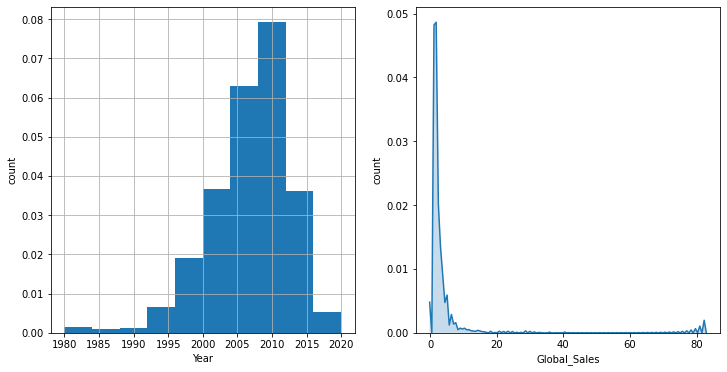

In [6]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
df['Year'].hist(density=True)
plt.ylabel('count')
plt.xlabel('Year')

plt.subplot(122)
sns.kdeplot(df['Global_Sales'], shade=True, legend=False)
plt.ylabel('count')
plt.xlabel('Global_Sales')

plt.show()

Как видим год выпуска игр распределен нормально, а мировые продажи нет 

Построив Q-Q кривую видно что теоретическое значение квантиля на выборке и его реальное значение в данных распределены относительно нормально

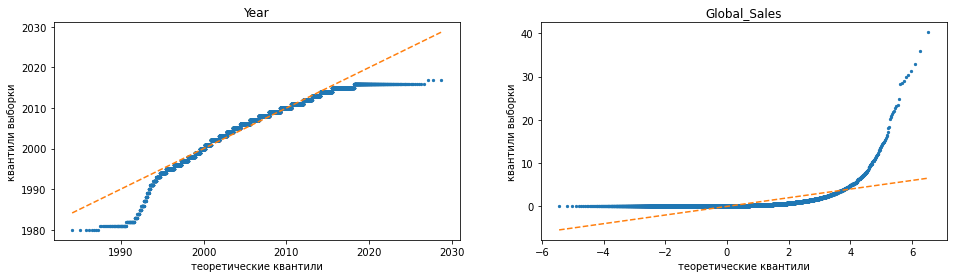

In [7]:
keys = ['Year', 'Global_Sales']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

In [8]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

Year
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.734124593324497
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9706591155560911
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9876491143511267

Global_Sales
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9524039040848294
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9792746113989638
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.989095071695385




Оценим нормальность выборок также на основании известных характеристик нормального распределения. В частности:

Если расчётные цифры оказываются близки к теоретическим, то распределения можно признать нормальными.

Тот факт, что распределения данных значений являются нормальными или близкими к ним позволяет использовать другие методы для анализа взаимосвязей в данных.

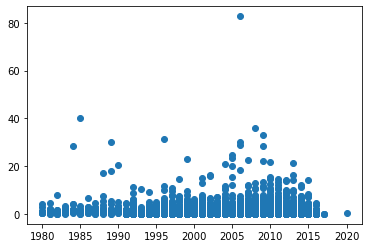

In [9]:
plt.scatter(df['Year'], df['Global_Sales'])
plt.show()

На графике видно что год выпуска и мировые продажи зависимы

In [10]:
ones = np.ones((16598,1))
x_pot = np.hstack((ones, df['Year'].values.reshape(16598,1)))

In [11]:

XTX = x_pot.T.dot(x_pot)
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x_pot.T).dot(df['Global_Sales'])
z = x_pot.dot(b)
e = df['Global_Sales'] - z

In [12]:
R = 1 - sum_of_squares(e) / sum_of_squares(np.array(df['Global_Sales']))
R

0.0055510360998782815

Рассчитаем коэффициенты регрессии и значения для для каждого из значений выборок. Результат расчёт показывает, что регрессия плохо описывает зависимость между данными и скорее всего зависимости нет.

In [13]:
n = 16598
m = 1

k1 = m
k2 = n - m - 1

k1, k2

(1, 16596)

In [14]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

3.8420192050271598

In [15]:
F = (R / k1) / ((1 - R) / k2)
F

92.63923887282829

Построим статистический тест с нулевой гипотезой о том, что зависимости между годом выпуска и и мировыми продажами нет.

Не смотря на маленькое значение коэффициента детерминации зависимость есть.

Так как результат расчёта F > t, то зависимость есть.

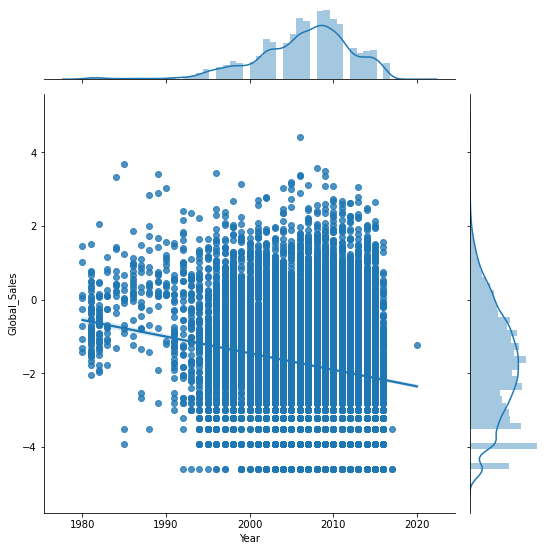

In [16]:
grid = sns.jointplot(df['Year'], np.log(df['Global_Sales']), kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

Визуализировав графики , видно что действительно зависимость есть 

In [17]:
df['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

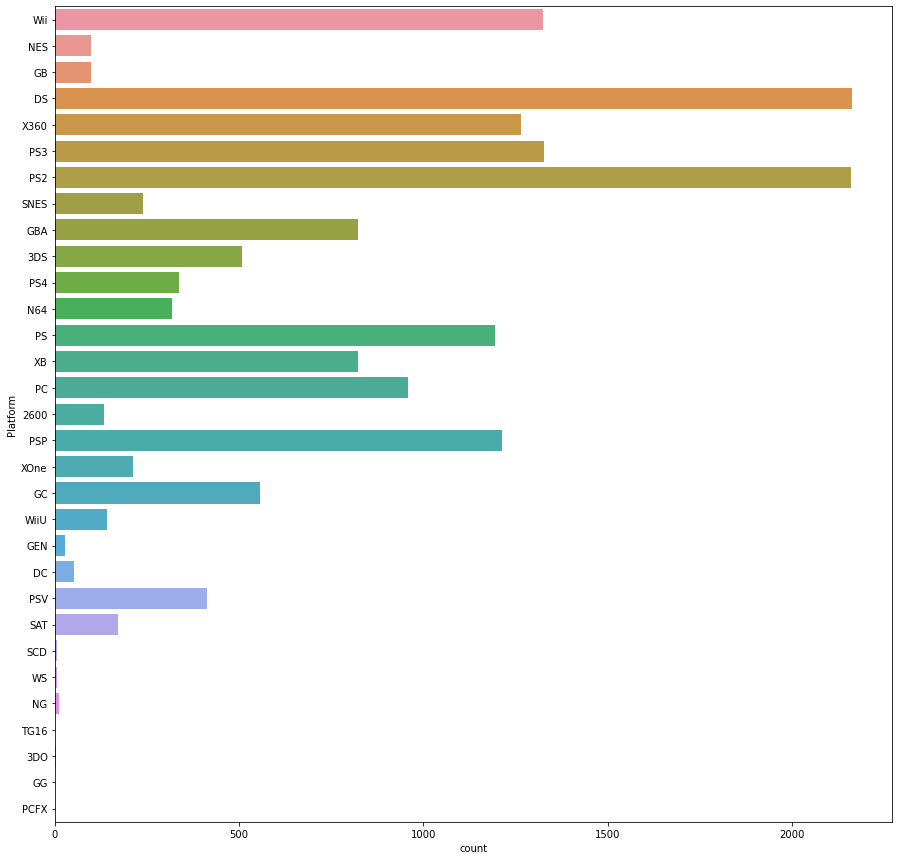

In [18]:
plt.rcParams['figure.figsize']=(15,15)

sns.countplot(y='Platform', data=df)

Визуализация распределения количества игр между платформами

In [19]:
df.pivot_table(values='Global_Sales', index='Genre', columns='Year')

Year,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2020.0
Genre,,,,,,,,,,,,,,,,,,,,,
Action,0.3400,0.5936,0.362222,0.408571,1.850000,1.7600,2.290000,0.560,0.8750,2.320000,...,0.512353,0.520531,0.497741,0.458797,0.846081,0.532366,0.277255,0.167311,0.01,NaN
Adventure,NaN,NaN,NaN,0.400000,NaN,NaN,NaN,4.380,NaN,NaN,...,0.146667,0.107597,0.147963,0.103276,0.110167,0.080800,0.148704,0.053235,NaN,NaN
Fighting,0.7700,NaN,NaN,NaN,NaN,1.0500,NaN,2.710,NaN,NaN,...,0.606604,0.372250,0.453600,0.327931,0.360500,0.702174,0.370476,0.275714,NaN,NaN
Misc,0.6775,NaN,0.870000,2.140000,1.450000,NaN,NaN,NaN,NaN,1.280000,...,0.371691,0.481891,0.304783,0.603158,0.610714,0.577561,0.299744,0.065000,NaN,NaN
Platform,NaN,2.3100,1.006000,1.386000,0.690000,10.7925,1.565000,0.870,6.9325,6.886667,...,1.416897,1.029032,0.759730,1.545833,0.678919,0.889000,0.432143,0.207000,NaN,NaN
Puzzle,NaN,1.1200,3.343333,0.780000,1.046667,0.8025,NaN,NaN,5.5800,7.550000,...,0.257089,0.248444,0.118837,0.160000,0.330000,0.187500,0.116667,NaN,NaN,NaN
Racing,NaN,0.4800,0.785000,NaN,1.983333,NaN,1.960000,NaN,2.1400,NaN,...,0.407024,0.612807,0.538615,0.482000,0.815000,0.618148,0.416842,0.082000,NaN,NaN
Role-Playing,NaN,NaN,NaN,NaN,NaN,NaN,2.520000,1.550,1.9600,1.100000,...,0.465049,0.684660,0.561789,0.612949,0.632676,0.503956,0.467179,0.169000,0.02,NaN
Shooter,3.5350,1.0040,0.758000,0.480000,10.366667,1.0000,0.972500,0.355,0.5100,1.200000,...,0.768022,0.955679,1.057021,1.517917,1.064407,1.404255,1.945588,0.569375,NaN,NaN


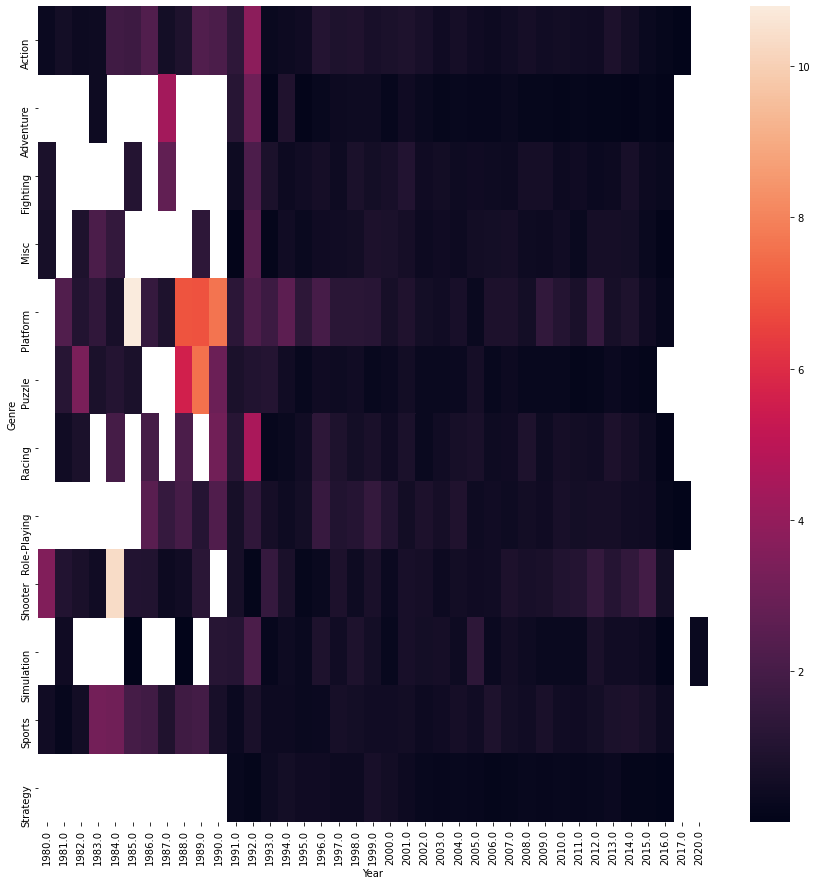

In [20]:
global_genre_year = df.pivot_table(
    values='Global_Sales', index='Genre', columns='Year')
sns.heatmap(global_genre_year,cmap="YlGnBu");


На этой тепловой карте показано распределение проданных игр по жанрам в разрезе года выпуска

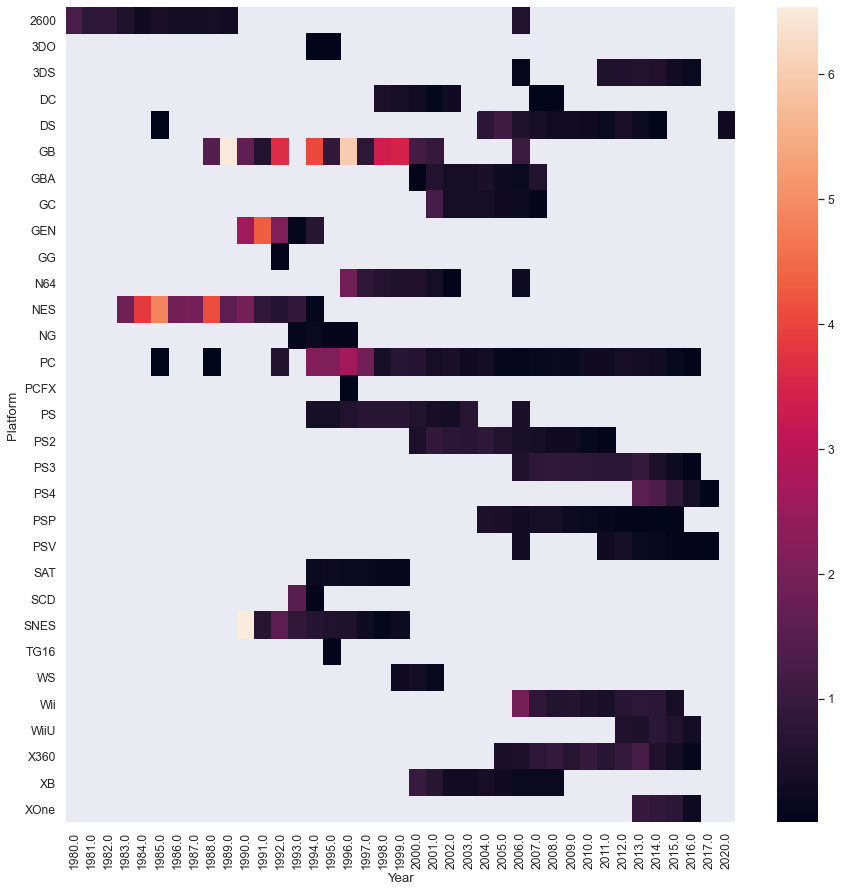

In [26]:
global_genre_year = df.pivot_table(
    values='Global_Sales', index='Platform', columns='Year')
sns.heatmap(global_genre_year);

На этой тепловой карте показано распределение вышедших игр по платформам в разрезе года выпуска

Проведём анализ зависимостей методом кореляции Кендала в данных 

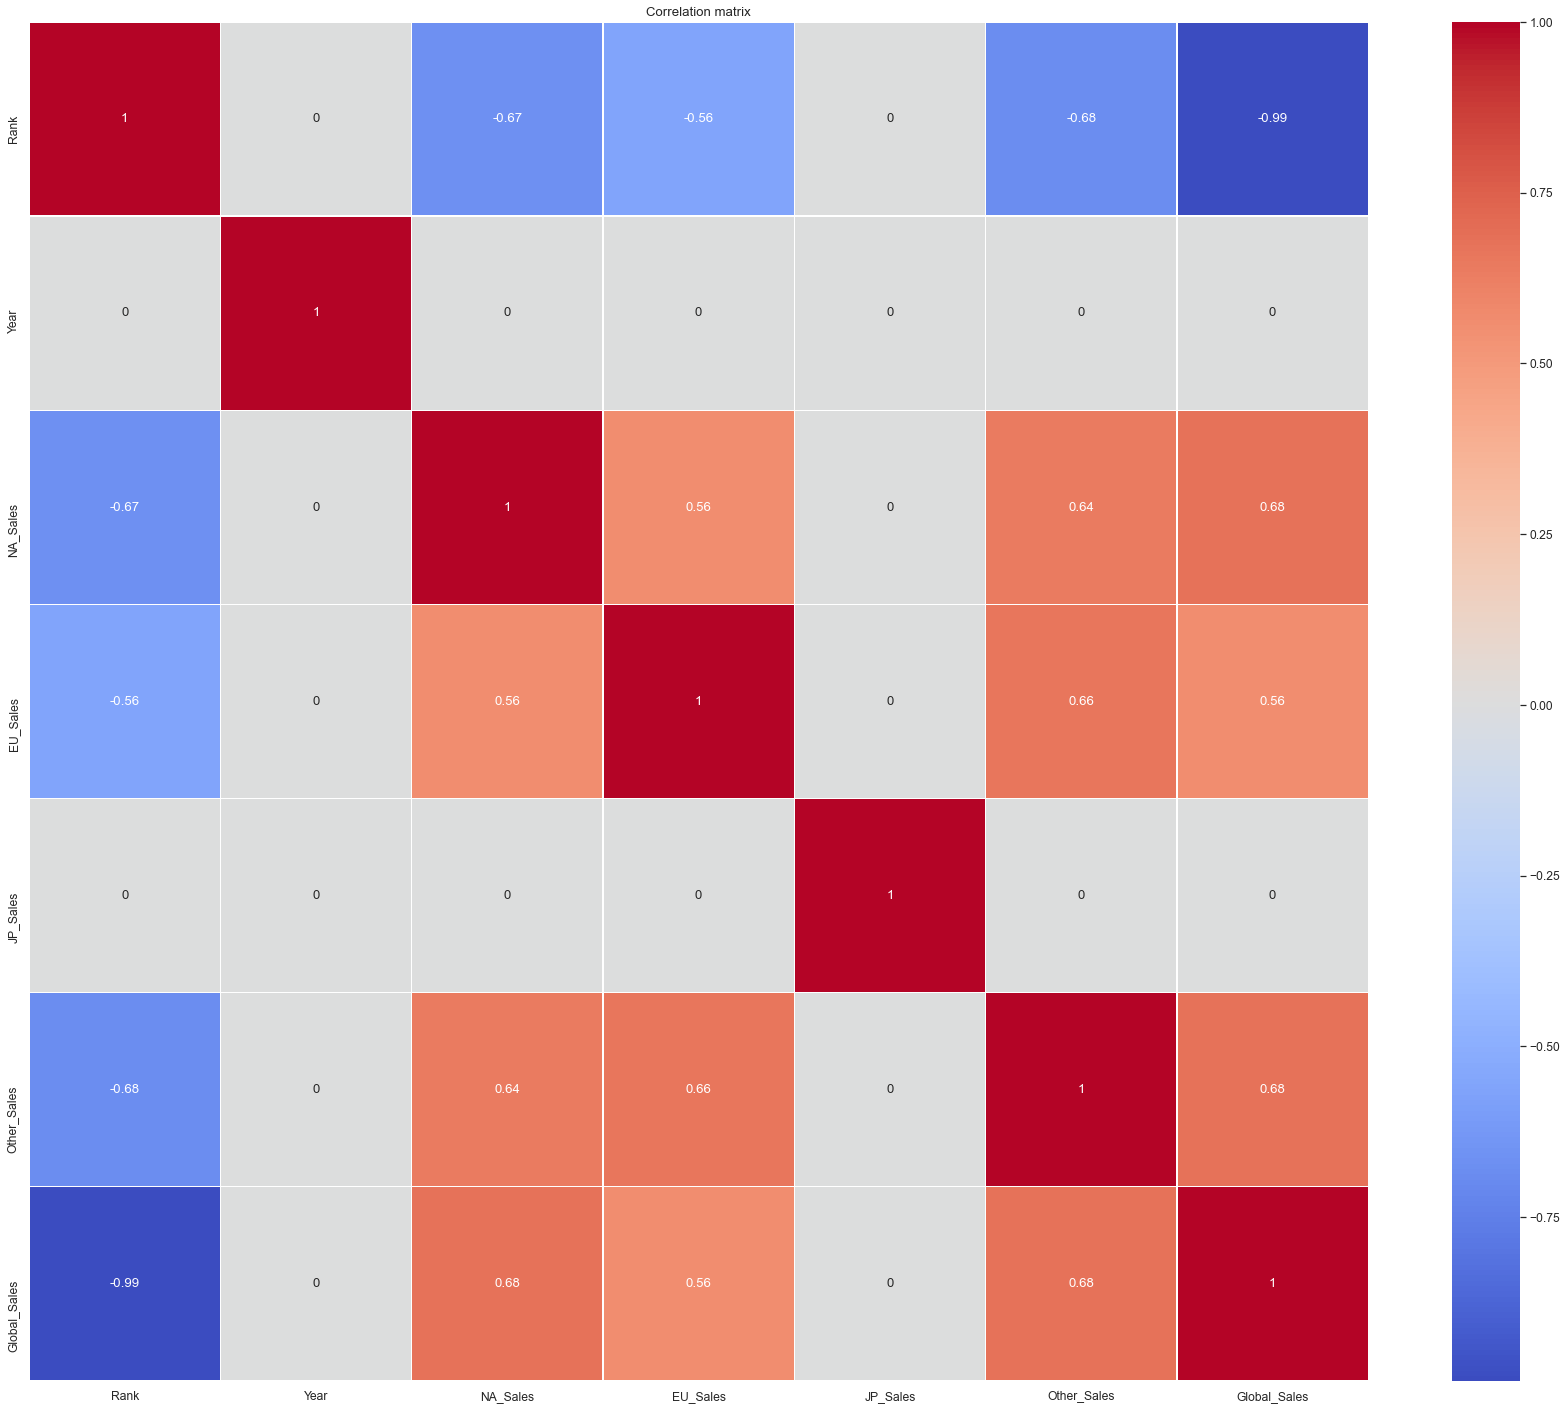

In [22]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.1)

corr_matrix = df.corr(method='kendall')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.3, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


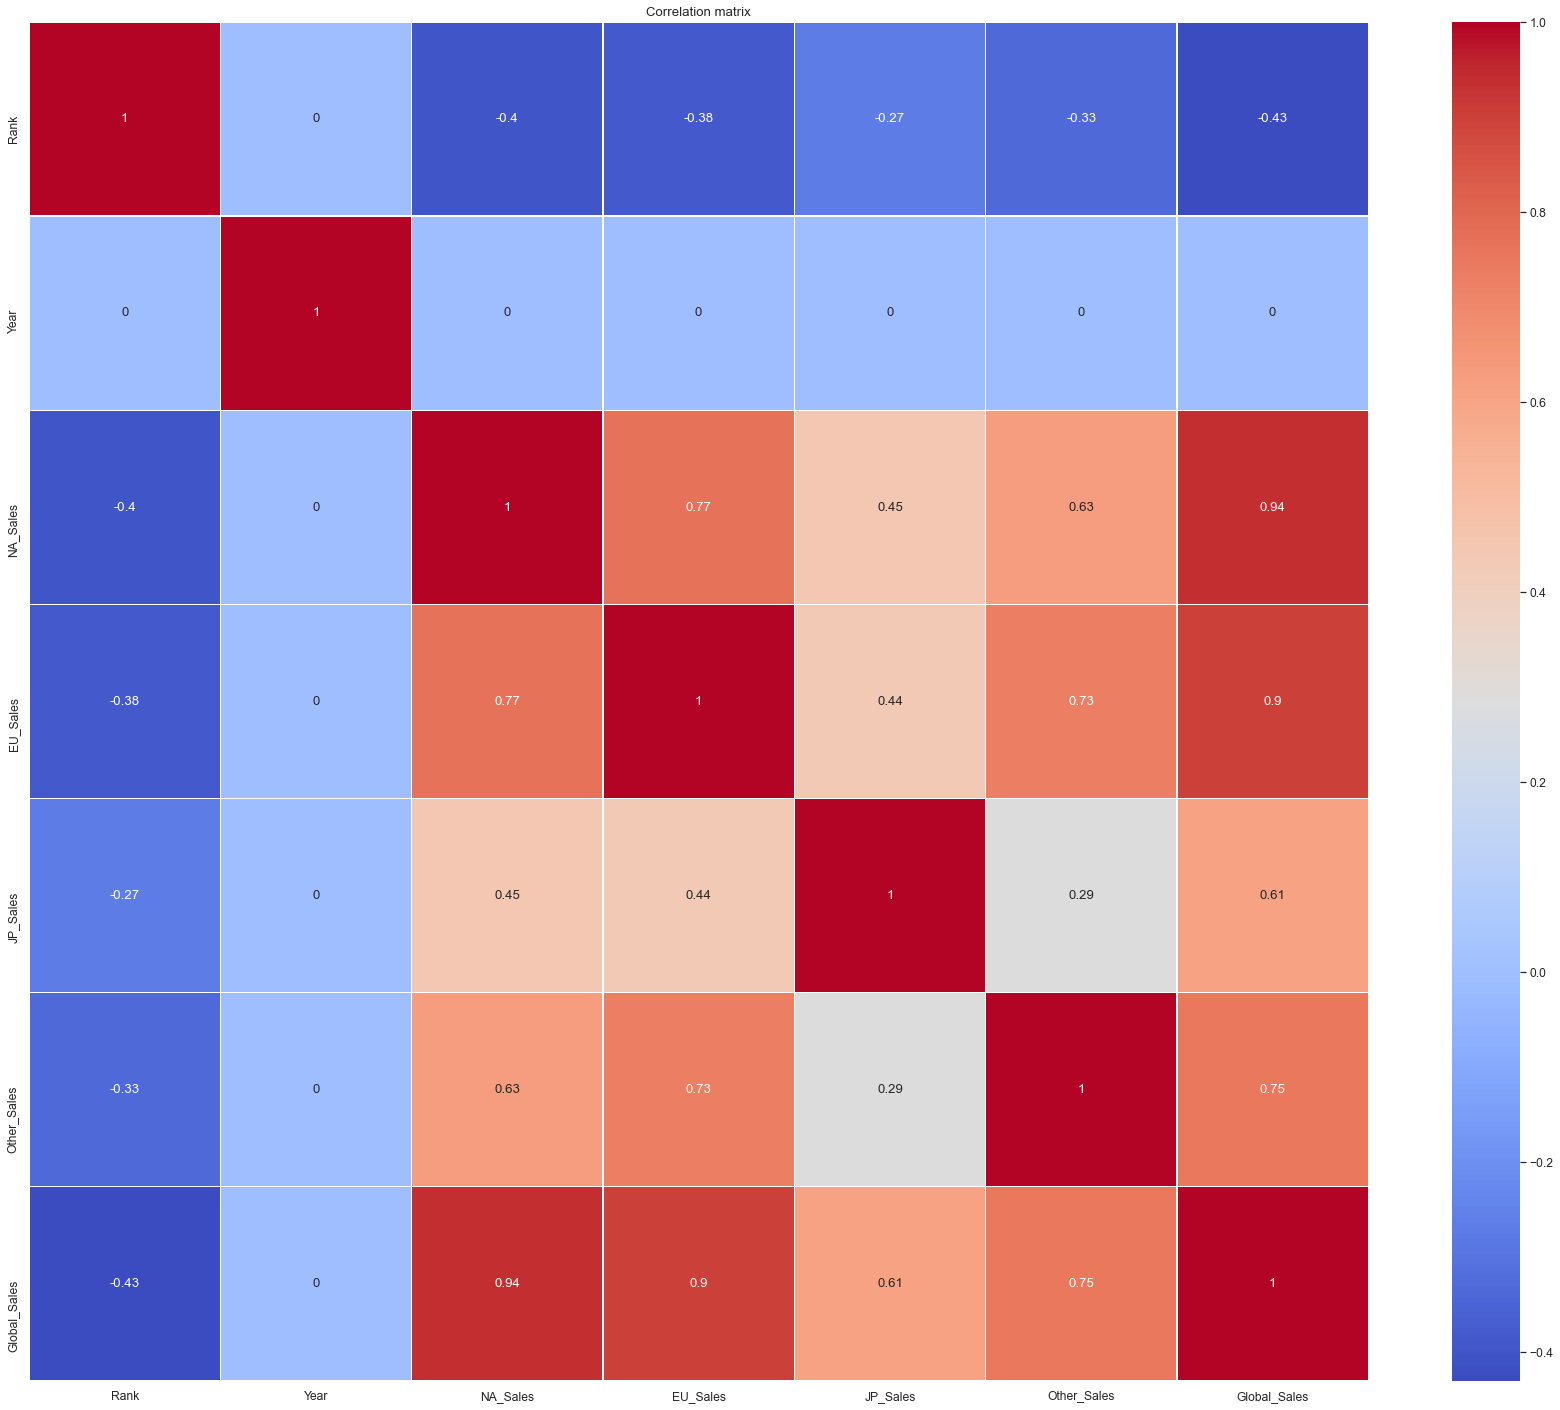

In [23]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.1)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.3, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


In [24]:
df['grouped_platform_year'] = df.groupby(by=['Platform'], as_index=False)['Year'].transform(lambda s: np.median(s.values))

df['grouped_genre_year'] = df.groupby(by=['Genre'], as_index=False)['Year'].transform(lambda s: np.median(s.values))

df['grouped_Genre'] = df.groupby(by=['Genre'], as_index=False)['Global_Sales'].transform(lambda s: np.median(s.values))

df['grouped_Genre_jp'] = df.groupby(by=['Genre'], as_index=False)['JP_Sales'].transform(lambda s: np.median(s.values))

df['grouped_Genre_na'] = df.groupby(by=['Genre'], as_index=False)['NA_Sales'].transform(lambda s: np.median(s.values))

df['grouped_Genre_eu'] = df.groupby(by=['Genre'], as_index=False)['EU_Sales'].transform(lambda s: np.median(s.values))

df['grouped_Genre_other'] = df.groupby(by=['Genre'], as_index=False)['Other_Sales'].transform(lambda s: np.median(s.values))

df['grouped_platform_gl'] = df.groupby(by=['Platform'], as_index=False)['Global_Sales'].transform(lambda s: np.median(s.values))

df['grouped_platform_jp'] = df.groupby(by=['Platform'], as_index=False)['JP_Sales'].transform(lambda s: np.median(s.values))

df['grouped_platform_na'] = df.groupby(by=['Platform'], as_index=False)['NA_Sales'].transform(lambda s: np.median(s.values))

df['grouped_platform_eu'] = df.groupby(by=['Platform'], as_index=False)['EU_Sales'].transform(lambda s: np.median(s.values))

df['grouped_platform_other'] = df.groupby(by=['Platform'], as_index=False)['Other_Sales'].transform(lambda s: np.median(s.values))

#sns.distplot(df.groupby('grouped_platform')['Rank'].nunique())
#df.head()

Построим матрицу корреляции , и сгруппируем информацию о продажах в зависимости от платформы , жанра.

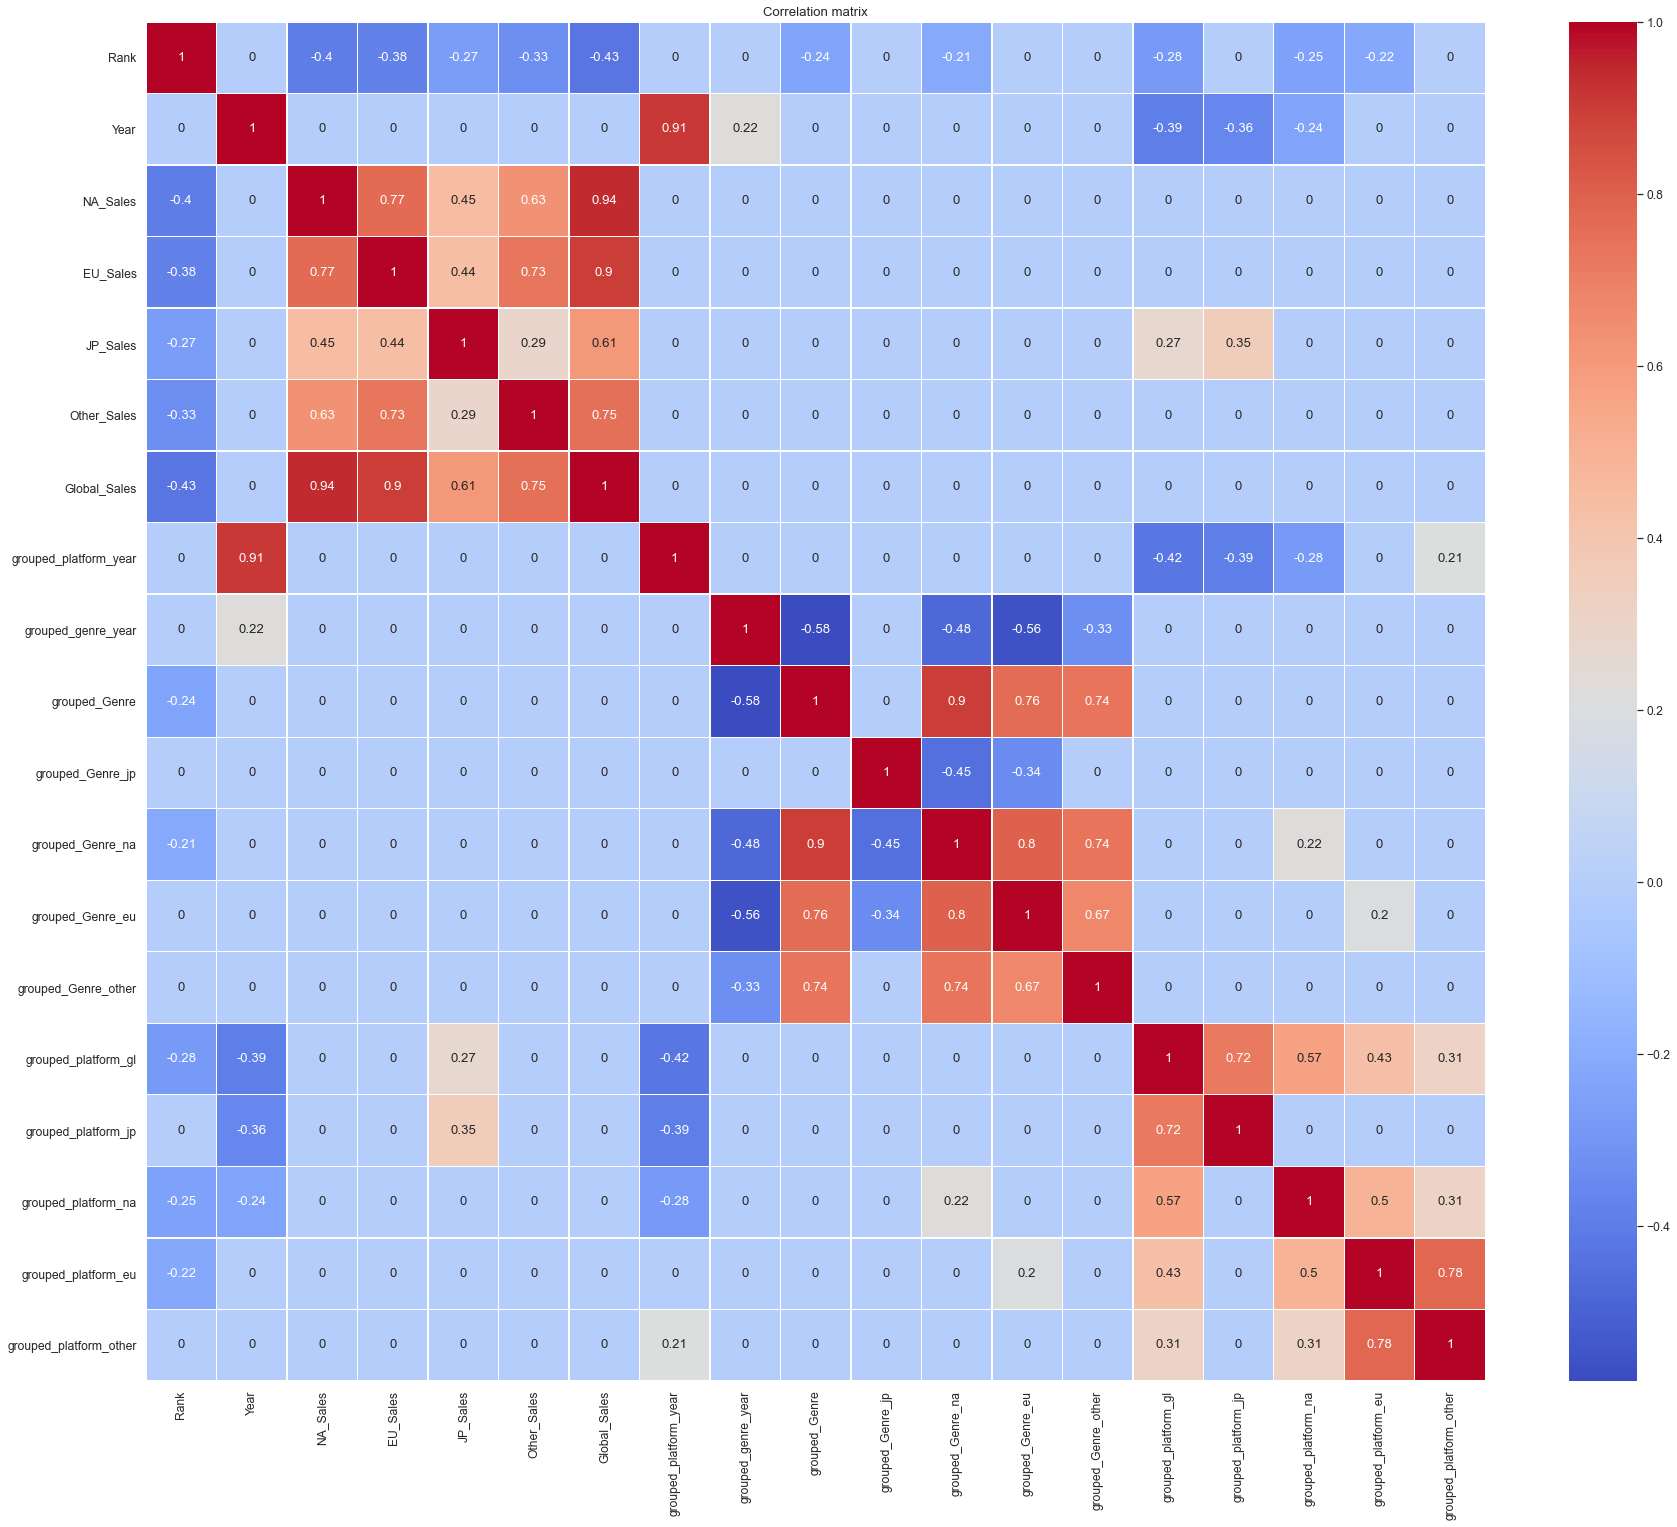

In [25]:
plt.figure(figsize = (30,25))

sns.set(font_scale=1.1)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.3, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Вывод

Продажи зависят от региона и платформы на которой выходит игра. Но сильно заметно  это видно только в японском регионе , предпочтение в жанрах и платформах в других регионах не сильно отличается. Так же видно что очень большое количество игр продается маленькими тиражами. 